# [Multivariate time series forecasting using LSTM](https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py) 

In [33]:
# %reset -f
from pprint import pprint
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler 
import plotly.express as ex
from functionsAll import lstmMultiSplit

## Functions

In [69]:
def lstmMultiSplit(df, n_past, n_future):
    """
    Split the data into training x and y sets.
    **Note: The 1st column of the df should be the label column and other columns should be features.**
    :param df: dataframe
    :param n_past: number of past days we want to use to predict the future
    :param n_future: number of days we want to look into the future based on the past days
    :return: trainX and trainX train sets
    """
    trainX = []
    trainY = []

    # n_future = 1
    # n_past = 5
    
    for i in range(n_past, len(df) - n_future +1):
        trainX.append(df[i - n_past:i, 0:df.shape[1]])
        trainY.append(df[i + n_future - 1:i + n_future, 0])
    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY

## Data pre-processing.

In [24]:
df = pd.read_csv("../Data/cleanned/zusammen.csv", parse_dates=["date"])
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.week
df.drop(columns=['date','rohwert'], inplace= True)
# Conclude with 11 features, 1 label.
df = df[[ 'wert', 'day', 'month', 'dayofyear', 'year', 'weekday', 'week', 'hour','temp', 'dwpt', 'rhum', 'prcp']]
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

/home/cluster_home/yash/workspace/AutoMLRepo/Auto-ML-On-De-Pollution/autoMLVenv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



## Scale the Training dataset and split it into Train Test Split.

In [4]:
scaler = StandardScaler()
scaler = scaler.fit(df)
scaledDf = scaler.transform(df)
train = scaledDf[:23000]
test = scaledDf[23000:] 

In [10]:
# Verifying the data
# pprint(df[0:1])
# pprint(scaledDf[0:1])
# pprint(scaler.inverse_transform(scaledDf[0]))

In [72]:
trainX, trainY = lstmMultiSplit(df=train, n_past=5, n_future=1)
testX, testY = lstmMultiSplit(df=test, n_past=5, n_future=1)

## Model

In [73]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(trainX, trainY, epochs=30, batch_size=14, validation_split=0.1, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 128)            72192     
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 64)             49408     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 134,049
Trainable params: 134,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1479/1479 [==============================] - 15s 9ms/step - loss: 0.6339 - val_loss: 0.2595
Epoch 2/30


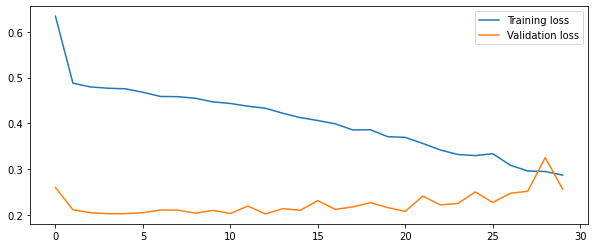

In [115]:
rcParams['figure.figsize'] = 10,4
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [76]:
model.save('../models/ml04.h5')
# from tensorflow import keras
# testmodel = keras.models.load_model('../models/ml04.h5')

In [80]:
prediction = model.predict(testX)

In [81]:
prediction = np.repeat(prediction, 12, axis=-1)
realPrediction = scaler.inverse_transform(prediction)
realPrediction = realPrediction[:,0]
yt = df.query('index >= 23000')
yt = yt['wert']
yt.reset_index(drop=True, inplace=True)

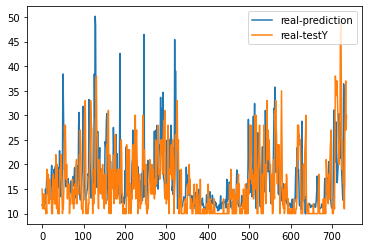

In [85]:
plt.plot(realPrediction, label='real-prediction')
plt.plot(yt, label='real-testY')
plt.legend() 
plt.show()

In [98]:
pdf = pd.DataFrame(data=realPrediction,columns=['prediction'])
pdf['Real'] = yt
pdf['Error'] = pdf['prediction'] - pdf['Real']

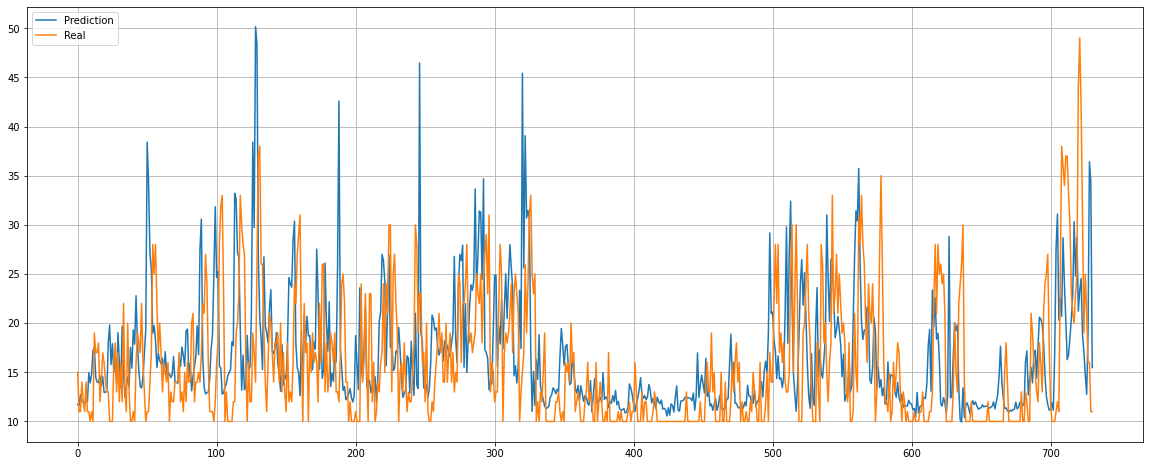

In [113]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,8
plt.plot(pdf.prediction, label='Prediction')
plt.plot(pdf.Real, label='Real')
plt.legend()
plt.grid()
plt.show()

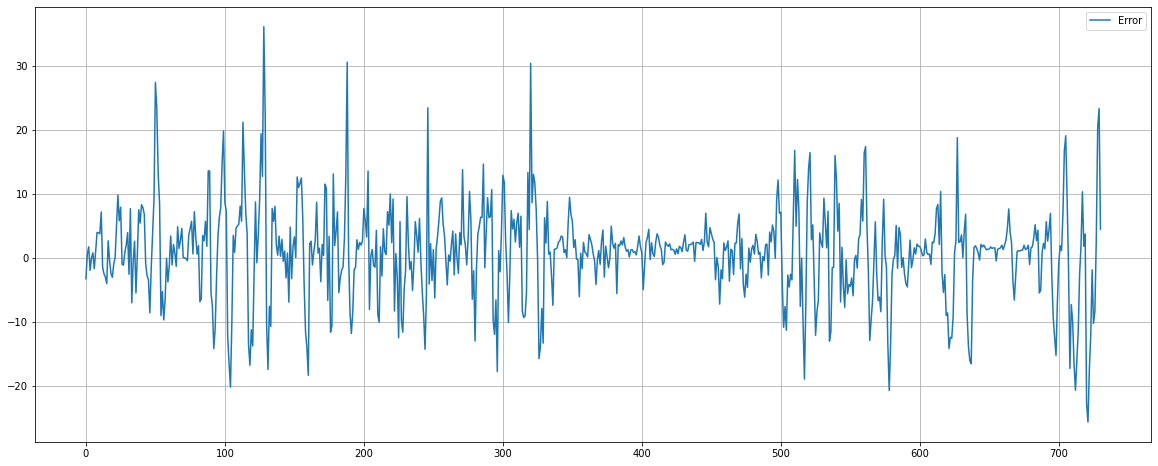

In [114]:
plt.plot(pdf.Error, label='Error')
plt.legend()
plt.grid()
plt.show()